## Setup

In [185]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances

#fuzzy string matching 
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

#hierarchical clustering 
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt



In [186]:
#loading the  rap dataset 
df= pd.read_pickle('df_rap_7k.pickle')

In [187]:
#genres from list to string
def listToString(s): 
    str1 = "" 
    for ele in s: 
        str1 += ele  
    # return string  
    return str1 
df['genres'] = df['artist_genres'].apply(lambda x: listToString(x))

In [188]:
#getting clean lyrics (as a string for each song)
lyricslist = []
for i in df['lyrics_clean_split']:
    
    full_lyrics = ' '.join(i)
    lyricslist.append(full_lyrics)

df['lyrix'] = lyricslist 
df['lyrix'] = df['lyrix'].str.replace('embedshare urlcopyembedcopy', '')

In [189]:
#engineering the year of release variable
import datetime 
df['track_release_year'] = pd.DatetimeIndex(df['track_release_date']).year

In [190]:
#unique artist ids and names 
artists_df = df.loc[df['artist_id'].isin(df.artist_id.unique())][['artist_id', 'artist_name']].drop_duplicates(subset = ["artist_id"])
artists_df.head()

,artist_id,artist_name
0,3M1quhETLChtt9NHKVaajX,Quin Nfn
1,0nQlnRkAhiWnSjTmB4JkfK,Sons of Light
2,0FtsMKmZEq8fBWqdSOWtqp,03 Greedo
3,0c173mlxpT3dSFRgMO8XPh,Big Sean
4,0auu2itHTxEdAMRHvx7CyG,Das EFX


In [191]:
#getting artist names and ids 
artist_id = df.artist_id.unique()
len(artist_id)

artist_name = []
for i in range(len(artist_id)): 
    name = artists_df[artists_df['artist_id'] ==artist_id[i]]['artist_name'].item()
    artist_name.append(name)


## Functions

In [192]:
#getting artist lyric pool by ID across ALL data
def artistLyricPool(artist_id, df):
    #getting artist song data
    lyrics_artist = df.loc[df['artist_id'] == artist_id]['lyrix']
    #aggregating lyrics
    lyric_pool = ""
    for song in lyrics_artist: 
        full_lyrics = ''.join(song)
        lyric_pool+= full_lyrics
    return lyric_pool

In [193]:
#getting artist lyric pool by ID for a specific year
def artistLyricPoolByYear(artist_id, df, year):
    #getting artist song data
    lyrics_artist = df.loc[df['artist_id'] == artist_id][['lyrix', 'track_release_year']]
    lyrics_artist_year = lyrics_artist.loc[lyrics_artist['track_release_year'] == year]['lyrix']
    #aggregating lyrics
    lyric_pool = ""
    for song in lyrics_artist_year: 
        full_lyrics = ''.join(song)
        lyric_pool+= full_lyrics
    return lyric_pool

In [194]:
#getting artist lyric pool by ID for a specific year
def artistLyricPoolByYearRange(artist_id, df, year1, year2):
    #getting artist song data
    lyrics_artist = df.loc[df['artist_id'] == artist_id][['lyrix', 'track_release_year']]
    lyrics_artist_year = lyrics_artist.loc[lyrics_artist['track_release_year'].between(year1, year2)]['lyrix']
    #aggregating lyrics
    lyric_pool = ""
    for song in lyrics_artist_year: 
        full_lyrics = ''.join(song)
        lyric_pool+= full_lyrics
    return lyric_pool

In [195]:
#function test examples
regular_pool_test = artistLyricPool('4MCBfE4596Uoi2O4DtmEMz', df)
byyear_pool_test = artistLyricPoolByYear('4MCBfE4596Uoi2O4DtmEMz', df, 2020)
range_test = artistLyricPoolByYearRange('4MCBfE4596Uoi2O4DtmEMz', df, 2019,2020)


In [196]:
#function that outputs a count vectorized 
def count_vec_output(corpus1, corpus2): 

    tempDataFrame=pd.DataFrame({'compared_artist':[corpus2]})
    tempDataFrame=tempDataFrame.transpose()
    base_artist = pd.DataFrame({'base_artist':[corpus1]})
    base_artist=base_artist.transpose()
    frames = [tempDataFrame, base_artist]
    result = pd.concat(frames)
    result.columns = ['artists_work']
    result=result.reset_index()

    #building bag of words using frequency
    vec_words = CountVectorizer(decode_error='ignore')
    total_features_words = vec_words.fit_transform(result['artists_work'])

    return total_features_words

In [197]:
#function that outputs cosine similarity
def cosine_sim_score(corpus1, corpus2): 

    tempDataFrame=pd.DataFrame({'compared_artist':[corpus2]})
    tempDataFrame=tempDataFrame.transpose()
    base_artist = pd.DataFrame({'base_artist':[corpus1]})
    base_artist=base_artist.transpose()
    frames = [tempDataFrame, base_artist]
    result = pd.concat(frames)
    result.columns = ['artists_work']
    result=result.reset_index()

    #building bag of words using frequency
    vec_words = CountVectorizer(decode_error='ignore')
    total_features_words = vec_words.fit_transform(result['artists_work'])

    #Calculating pairwise cosine similarity
    subset_sparse = sparse.csr_matrix(total_features_words)
    total_features_base=subset_sparse
    total_features_comp=subset_sparse[0,]
    similarity=1-pairwise_distances(total_features_comp,total_features_base, metric='cosine')

    #assigning similarity scores to a dataframe 
    similarity=pd.DataFrame(similarity)
    similarity=similarity.transpose()
    similarity.columns = ['similarity']
    similarity=similarity.drop(similarity.index[[0]])
    return similarity.iloc[0,0]


In [198]:
#function that creates cosine similarity matrix over all years 
def cosine_matrix_generator(artist_id, artist_name, df):
    sub_artists = artist_id
    sub_names = artist_name

    cosin_df = pd.DataFrame(columns = sub_artists)
    for i in sub_artists: 
        sim_score = []
        #merging attibutes to the review
        for j in sub_artists: 
            if i == j: 
                sim = 1 
                sim_score.append(sim)
            else:
                sim = cosine_sim_score(artistLyricPool(i,df), artistLyricPool(j,df))
                sim_score.append(sim)

        cosin_df[i] = sim_score
            
    #renaming the index 
    cosin_df.columns = sub_names
    cosin_df.index = sub_names
    return cosin_df  

In [199]:
#function that creates cosine similarity matrix over a range of years  
def cosine_matrix_generator2(artist_id, artist_name, df, year1, year2):
    sub_artists = artist_id
    sub_names = artist_name

    cosin_df = pd.DataFrame(columns = sub_artists)
    for i in sub_artists: 
        sim_score = []
        #merging attibutes to the review
        for j in sub_artists: 
            if i == j: 
                sim = 1 
                sim_score.append(sim)
            else:
                sim = cosine_sim_score(artistLyricPoolByYearRange(i,df, year1,year2), artistLyricPoolByYearRange(j,df,year1, year2))
                sim_score.append(sim)

        cosin_df[i] = sim_score
            
    #renaming the index 
    cosin_df.columns = sub_names
    cosin_df.index = sub_names
    return cosin_df  

In [218]:
def mdsdf_generator(cosin_df):
    from sklearn.manifold import MDS
    embedding = MDS(n_components=2, random_state = 42)
    diss_df_transformed = embedding.fit_transform(cosin_df)
    diss_df_transformed.shape

    mds_df = pd.DataFrame(diss_df_transformed)
    mds_df['artist'] = list(cosin_df.columns)
    mds_df.columns = ['component0', 'component1', 'artist']

    return mds_df


In [200]:
#creates a metric mds plot with annotations 
def mdsplot_generator(cosin_df):
    from sklearn.manifold import MDS
    embedding = MDS(n_components=2, random_state = 42)
    diss_df_transformed = embedding.fit_transform(cosin_df)
    diss_df_transformed.shape

    mds_df = pd.DataFrame(diss_df_transformed)
    mds_df['artist'] = list(cosin_df.columns)
    mds_df.columns = ['component0', 'component1', 'artist']

    import matplotlib.pyplot as plt
    from scipy.spatial import ConvexHull
    import numpy as np

    with plt.style.context('fivethirtyeight'):
        fig, ax = plt.subplots(1, figsize=(8,8))

        # plot data
        x = mds_df.component0
        y = mds_df.component1
        plt.scatter(x, y, s=100)
        
        n = mds_df.artist
        for i, txt in enumerate(n):
            ax.annotate(txt, (x[i], y[i]))


In [201]:
#creates a metric mds plot without annotations 
def mdsplot_generator_wo(cosin_df):
    from sklearn.manifold import MDS
    embedding = MDS(n_components=2, random_state = 42)
    diss_df_transformed = embedding.fit_transform(cosin_df)
    diss_df_transformed.shape

    mds_df = pd.DataFrame(diss_df_transformed)
    mds_df['artist'] = list(cosin_df.columns)
    mds_df.columns = ['component0', 'component1', 'artist']

    import matplotlib.pyplot as plt
    from scipy.spatial import ConvexHull
    import numpy as np

    with plt.style.context('fivethirtyeight'):
        fig, ax = plt.subplots(1, figsize=(8,8))

        # plot data
        x = mds_df.component0
        y = mds_df.component1
        plt.scatter(x, y, s=100)
        
        # n = mds_df.artist
        # for i, txt in enumerate(n):
        #     ax.annotate(txt, (x[i], y[i]))


In [202]:
#function that fuzzy matches popular artists
def fuzzy_merge(df_1, df_2, key1, key2, threshold=95, limit=2):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()
    new_df = df_1.copy()
    
    m = new_df[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    new_df['matches'] = m
    
    m2 = new_df['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    new_df['matches'] = m2

    import numpy as np
    new_df['matches'].replace('', np.nan, inplace=True)

    new_df = new_df[new_df['matches'].notna()]
    
    return new_df

In [203]:
#function that subsets artist ids and names 
def artist_id_name_byperiod(artists_90s, year1, year2):
    #check if lyrics  are available
    all_rapper_pools = []

    for rapper_id in artists_90s['artist_id']:
        lyrix_pool = artistLyricPoolByYearRange(rapper_id, df, year1, year2)
        all_rapper_pools.append(lyrix_pool)

    rapperpools = pd.DataFrame({'artist_id':list(artists_90s['artist_id']), 'Lyrix_Pool':all_rapper_pools})
    rapperpools = rapperpools.merge(artists_90s[['artist_id' , 'artist_name']].drop_duplicates(), how='inner', on='artist_id')

    #dropping artists whose lyrics are not available
    rapperpools['Lyrix_Pool'].replace('', np.nan, inplace=True)
    rapperpools = rapperpools[rapperpools['Lyrix_Pool'].notna()]

    #merging it with
    artist2 =  artists_90s.copy()
    artist2 = artist2.merge(rapperpools[['artist_id' , 'artist_name']], how='inner', on='artist_id')
    
    #getting artist names and ids 
    artist_id = artist2.artist_id.unique()

    artist_name = []
    for i in range(len(artist_id)): 
        name = artists_df[artists_df['artist_id'] ==artist_id[i]]['artist_name'].item()
        artist_name.append(name)

    return artist_id, artist_name

In [204]:
#function that outputs a refined version of the cosine matrix 
def present_matrix(lift_df):
    import numpy as np
    np.tril(np.ones(lift_df.shape)).astype(np.bool)[0:10,0:10]
    df_lt = lift_df.where(np.tril(np.ones(lift_df.shape)).astype(np.bool))
    df_lt


    #dealing with null values 
    df_lt.fillna(df_lt.max().max()+1, inplace=True)

    def color_max_white(val, max_val):
        color = 'white' if val == max_val else 'black'
        return 'color: %s' % color

    def highlight_max(data, color='white'):
        attr = 'background-color: {}'.format(color)
        if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
            is_max = data == data.max()
            return [attr if v else '' for v in is_max]
        else:  # from .apply(axis=None)
            is_max = data == data.max().max()
            return pd.DataFrame(np.where(is_max, attr, ''),
                                index=data.index, columns=data.columns)

    max_val = df_lt.max().max()
    #df_lt.style.format("{:.2f}").background_gradient(cmap='YlGnBu', axis=None).applymap(lambda x: color_max_white(x, max_val)).apply(highlight_max, axis=None)

    def make_pretty(styler):
        styler.set_caption("Cosine Similarity")
        styler.background_gradient(cmap='YlGnBu', axis=None).applymap(lambda x: color_max_white(x, max_val)).apply(highlight_max, axis=None)
        return styler

    return make_pretty(df_lt.style)

## Cosine Similarity Matrix

In [205]:
#test run 
base  = artistLyricPool(artist_id[0],df)
comp = artistLyricPool(artist_id[1],df)
cosine_sim_score(base, comp)

0.31166725140105433

# Cosine Similarity: MDS Plot & K-means clustering

/Users/ananyanair/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


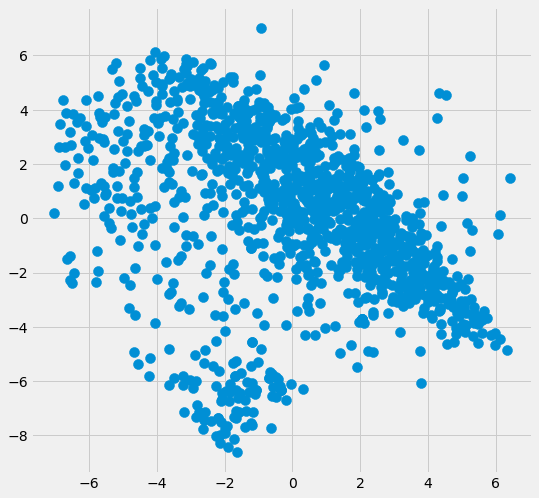

In [206]:
#loading the cosine matrix for all artists (across all time periods)
cosin_df = pd.read_pickle('cosine.pickle')
mdsplot_generator_wo(cosin_df)

# Evolution over the years 

In [207]:
#lists of scraped artist prominent in the 90s
rappers90s = pd.read_csv('90srappers.csv')
rappers90s.head()

# subset of rappers relevant to nas 
rappers_sub = pd.read_csv('subset.csv')
rappers_sub.head()

#all artists from the master data
artists_df.head() 

,artist_id,artist_name
0,3M1quhETLChtt9NHKVaajX,Quin Nfn
1,0nQlnRkAhiWnSjTmB4JkfK,Sons of Light
2,0FtsMKmZEq8fBWqdSOWtqp,03 Greedo
3,0c173mlxpT3dSFRgMO8XPh,Big Sean
4,0auu2itHTxEdAMRHvx7CyG,Das EFX


In [208]:
#getting artists for the relevant time period whose lyrics are available in the dataset 
artists_90s = fuzzy_merge(artists_df, rappers90s,'artist_name', 'names')

artists_sub = fuzzy_merge(artists_df, rappers_sub,'artist_name', 'names')


In [209]:
artists_sub

,artist_id,artist_name,matches
24,20qISvAhX20dpIbOOzGK3q,Nas,Nas
68,7hJcb9fa4alzcOq3EaNPoG,Snoop Dogg,Snoop Dogg
102,3PyWEKLWI0vHPmoNrIX0QE,Rakim,Rakim
249,7dGJo4pcD2V6oG8kP0tJRR,Eminem,Eminem
362,3nFkdlSjzX9mRTtwJOzDYB,JAY-Z,Jay-Z
373,6DPYiyq5kWVQS4RGwxzPC7,Dr. Dre,Dr. Dre
2116,1YfEcTuGvBQ8xSD1f53UnK,Busta Rhymes,Busta Rhymes
2208,2Xu7q46Hf02xOoEIm4E1Qs,Big Pun,Big Pun
2602,3q7HBObVc0L8jNeTe5Gofh,50 Cent,50 Cent
2648,5spEJXLwD1sKUdC2bnOHPg,Bone Thugs-N-Harmony,Bone Thugs-N-Harmony


## Hierarchical Agglomerative Clustering 
Nas and relevant artists

In [210]:
# Agglomerative Hierarchical Clustering 
def hca(sims, label_values, linkage_method='ward', color_thresh=.3, figsize=(8, 8)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = label_values
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)


In [211]:
artist_id, artist_name = artist_id_name_byperiod(artists_sub, 1990, 2000)
cosin_df_sub = cosine_matrix_generator2(artist_id, artist_name, df,1990,2000)

<Figure size 432x288 with 0 Axes>

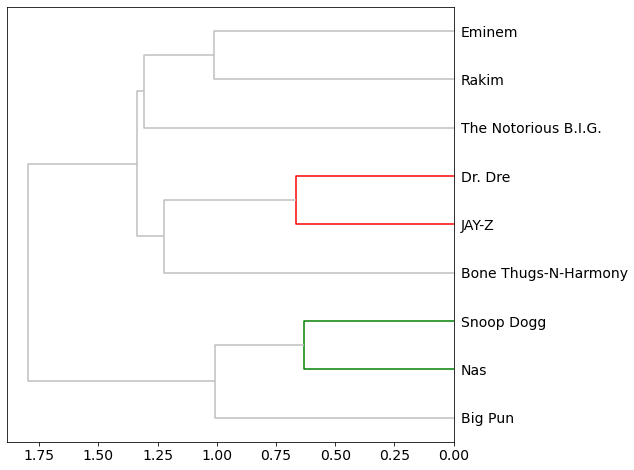

In [212]:
hca(cosin_df_sub, artist_name, color_thresh=1)

# 1990s
Mapping artists using Multi Dimensional Scaling (Using Cosine Similarity Matrix)

In [217]:
#outputs artists whose lyrics are available 
artist_id, artist_name = artist_id_name_byperiod(artists_90s, 1990, 2000)
cosin_df2 = cosine_matrix_generator2(artist_id, artist_name, df,1990,2000)
present_matrix(cosin_df2.head(10))


/var/folders/ng/_pmg5th94cv_sncvyjylvr0w0000gn/T/ipykernel_1366/2980030588.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.tril(np.ones(lift_df.shape)).astype(np.bool)[0:10,0:10]
/var/folders/ng/_pmg5th94cv_sncvyjylvr0w0000gn/T/ipykernel_1366/2980030588.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_lt = lift_df.where(np.tril(np.ones

,Eric B. & Rakim,Method Man,A Tribe Called Quest,Guru,Nas,Pete Rock & C.L. Smooth,Souls Of Mischief,Q-Tip,De La Soul,Snoop Dogg,AZ,Too $hort,Cypress Hill,LL Cool J,Gang Starr,Fat Joe,Rakim,KRS-One,Fugees,The Pharcyde,Goodie Mob,The Coup,Camp Lo,Cam’ron,Public Enemy,Eminem,RZA,JAY-Z,Brand Nubian,Dr. Dre,Ghostface Killah,Onyx,Canibus,Raekwon,Jurassic 5,Mos Def,Big Daddy Kane,Kris Kross,Queen Latifah,GZA,DJ Quik,Common,Coolio,Lords Of The Underground,Da Brat,Jeru The Damaja,Warren G,Mobb Deep,DJ Jazzy Jeff & The Fresh Prince,Tha Dogg Pound,The Lost Boyz,Naughty By Nature,Outkast,Special Ed,N.W.A.,Smif-N-Wessun,DMX,Killah Priest,Scarface,Will Smith,Mystikal,Beastie Boys,Big Pun,House Of Pain,Kool G Rap,Digital Underground,Ice Cube,Lost Boyz,Bone Thugs-N-Harmony,Chubb Rock,Westside Connection,M.O.P.,Foxy Brown,Dmx,Gza,Inspectah Deck,Bell Biv DeVoe,MC Eiht,The LOX,Ol' Dirty Bastard,Slick Rick,MC Ren,Eazy-E,Kurupt,Az,The Notorious B.I.G.
Eric B. & Rakim,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
Method Man,0.076174,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
A Tribe Called Quest,0.178456,0.343503,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
Guru,0.200717,0.299183,0.635209,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000

In [219]:
mds_df = mdsdf_generator(cosin_df2)

/Users/ananyanair/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


Nas


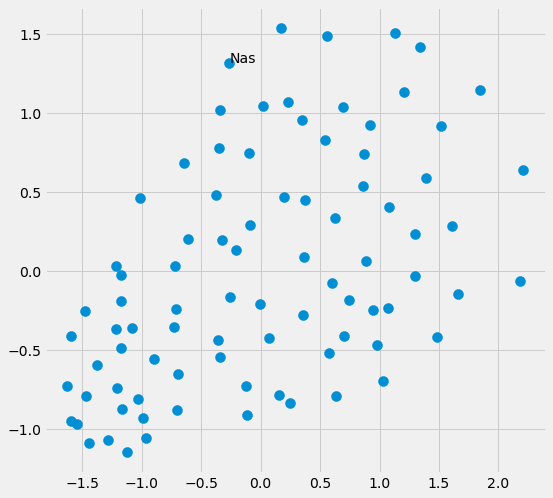

In [221]:
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import numpy as np

#annotation for Nas
ann_artists = ["Nas"]
points = []
for i in ann_artists:
    print(i)
    coords = []
    x1 = mds_df[mds_df.artist == i]['component0'].item()
    y1 = mds_df[mds_df.artist == i]['component1'].item()
    coords.append(x1)
    coords.append(y1)
    points.append(coords)


with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1, figsize=(8,8))

    # plot data
    x = mds_df.component0
    y = mds_df.component1
    plt.scatter(x, y, s=100)

    for i in range(len(ann_artists)):
        plt.annotate(ann_artists[i], (points[i][0], points[i][1]))


In [222]:
#dynamic plot 
import plotly.express as px
import plotly.io as pio
pio.renderers
pio.renderers.default = "notebook_connected"

fig = px.scatter(mds_df, x="component0", y="component1", hover_data=['artist'])
fig.show()


# 2000s 
Mapping artists using Multi Dimensional Scaling (Using Cosine Similarity Matrix)

In [224]:
rappers00s = pd.read_csv('00srappers.csv')
#getting artists for the relevant time period 
artists_00s = fuzzy_merge(artists_df, rappers00s,'artist_name', 'names')
#outputs artists whose lyrics are available 
artist_id, artist_name = artist_id_name_byperiod(artists_90s, 2000, 2010)
cosin_df2 = cosine_matrix_generator2(artist_id, artist_name, df,2000,2010)
present_matrix(cosin_df2.head(10))

/var/folders/ng/_pmg5th94cv_sncvyjylvr0w0000gn/T/ipykernel_1366/2980030588.py:4: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/var/folders/ng/_pmg5th94cv_sncvyjylvr0w0000gn/T/ipykernel_1366/2980030588.py:5: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



,Eric B. & Rakim,Method Man,Guru,Nas,Souls Of Mischief,Q-Tip,De La Soul,Snoop Dogg,Cypress Hill,LL Cool J,Fat Joe,Rakim,KRS-One,Fugees,The Pharcyde,Lil Wayne,Cam’ron,Talib Kweli,Eminem,JAY-Z,Brand Nubian,Dr. Dre,Ghostface Killah,Jurassic 5,Mos Def,Queen Latifah,Mase,Common,Lords Of The Underground,Mack 10,DJ Jazzy Jeff & The Fresh Prince,Tha Dogg Pound,Special Ed,Tech N9ne,Scarface,Will Smith,Mystikal,Beastie Boys,Phife Dawg,Busta Rhymes,Z-Ro,Ice Cube,50 Cent,Chubb Rock,M.O.P.,Biz Markie,Lil' Kim,"Pete Rock, CL Smooth",Nate Dogg,"CL Smooth, Pete Rock",Big L,Missy Elliott
Eric B. & Rakim,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
Method Man,0.123092,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
Guru,0.049084,0.256957,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
Nas,0.176803,0.491712,0.233966,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
Souls Of Mischief,0.198292,0.557424,0.281077,0.604428,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
Q-Tip,0.058734,0.279675,0.157872,0.360227,0.323018,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
De La Soul,0.144724,0.530458,0.317220,0.531282,0.631213,0.437059,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
Snoop Dogg,0.106587,0.462744,0.282995,0.419369,0.480857,0.214288,0.485446,1

In [ ]:
mds_df = mdsdf_generator(cosin_df2)

/Users/ananyanair/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning:

The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.



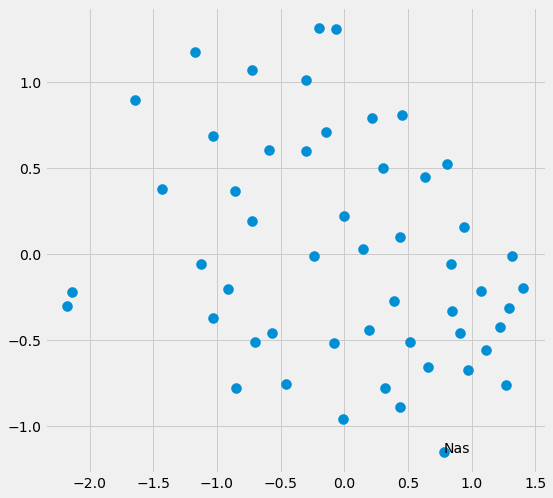

In [ ]:
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import numpy as np

with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1, figsize=(8,8))

    # plot data
    x = mds_df.component0
    y = mds_df.component1
    plt.scatter(x, y, s=100)

    plt.annotate('Nas', (0.7803726763, -1.1545695101))


In [ ]:
import plotly.express as px
import plotly.io as pio
pio.renderers
pio.renderers.default = "notebook_connected"

fig = px.scatter(mds_df, x="component0", y="component1", hover_data=['artist'])
fig.show()